عدد الصفوف قبل التنظيف: 414
عدد الصفوف بعد التنظيف: 303


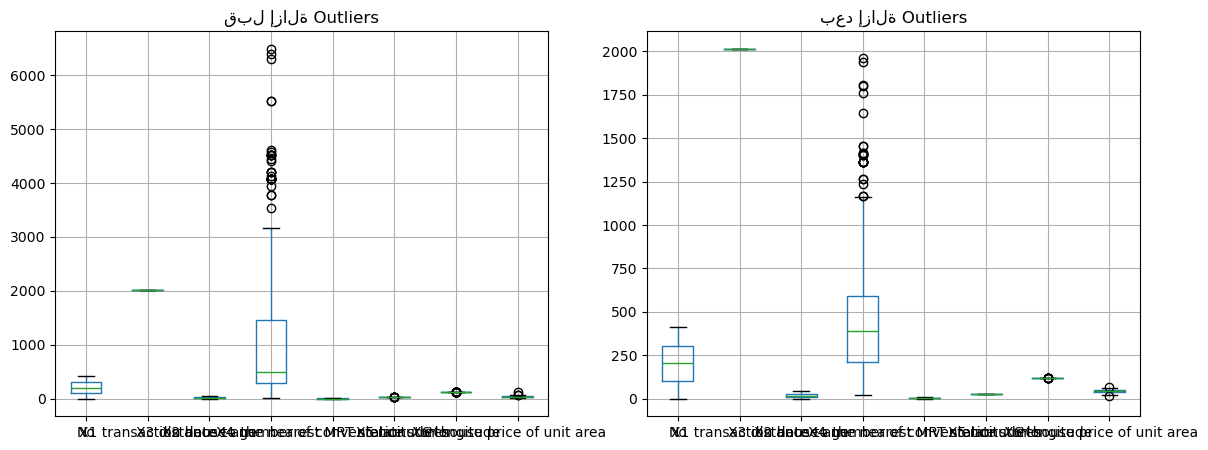


✔ تم حفظ البيانات النظيفة في 'cleaned_real_estate.csv'


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------
# دالة إزالة Outliers وحدها
# ----------------------------------------
def remove_outliers_and_save(input_file="Real estate.csv", output_file="cleaned_real_estate.csv"):
    # قراءة البيانات
    df = pd.read_csv(input_file)
    
    # دالة إزالة Outliers بطريقة IQR
    def remove_outliers_iqr(data, columns):
        df_clean = data.copy()
        
        for col in columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            
            df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
        
        return df_clean
    
    # اختيار الأعمدة الرقمية فقط
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    
    # إزالة الـ outliers
    df_clean = remove_outliers_iqr(df, numeric_cols)
    
    print("عدد الصفوف قبل التنظيف:", len(df))
    print("عدد الصفوف بعد التنظيف:", len(df_clean))
    
    # رسم Boxplot قبل وبعد التنظيف
    plt.figure(figsize=(14,5))
    
    plt.subplot(1,2,1)
    df.boxplot()
    plt.title("قبل إزالة Outliers")
    
    plt.subplot(1,2,2)
    df_clean.boxplot()
    plt.title("بعد إزالة Outliers")
    
    plt.show()
    
    # حفظ البيانات النظيفة
    df_clean.to_csv(output_file, index=False)
    print(f"\n✔ تم حفظ البيانات النظيفة في '{output_file}'")

remove_outliers_and_save()

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# ----------------------------------------
# دالة تقسيم البيانات وحدها
# ----------------------------------------
def split_and_save(input_file="cleaned_real_estate.csv", test_size=0.30, val_size=0.50, random_state=42):
    # قراءة البيانات النظيفة
    df_clean = pd.read_csv(input_file)
    
    # فصل الميزات عن الهدف
    X = df_clean.drop(columns=['Y house price of unit area'])
    y = df_clean['Y house price of unit area']
    
    # تقسيم البيانات
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=True
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=val_size, random_state=random_state, shuffle=True
    )
    
    # طباعة نتائج التقسيم
    print("=== Data Split Summary ===")
    print("Training set:   ", X_train.shape, y_train.shape)
    print("Validation set: ", X_val.shape,   y_val.shape)
    print("Test set:       ", X_test.shape,  y_test.shape)
    
    total = len(df_clean)
    print("\nPercentages:")
    print("Train:", round(len(X_train)/total*100, 2), "%")
    print("Val:  ", round(len(X_val)/total*100, 2), "%")
    print("Test: ", round(len(X_test)/total*100, 2), "%")
    
    # حفظ الملفات بعد التقسيم
    X_train.to_csv("X_train.csv", index=False)
    X_val.to_csv("X_val.csv", index=False)
    X_test.to_csv("X_test.csv", index=False)
    
    y_train.to_csv("y_train.csv", index=False)
    y_val.to_csv("y_val.csv", index=False)
    y_test.to_csv("y_test.csv", index=False)
    
    print("\n✔ تم حفظ الملفات بنجاح")

# ----------------------------------------
# استدعاء الدالة
# ----------------------------------------
split_and_save()


=== Data Split Summary ===
Training set:    (212, 7) (212,)
Validation set:  (45, 7) (45,)
Test set:        (46, 7) (46,)

Percentages:
Train: 69.97 %
Val:   14.85 %
Test:  15.18 %

✔ تم حفظ الملفات بنجاح


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# ==========================================================
#  الدالة الرئيسية مع Feature Engineering + Correlation Filtering
# ==========================================================

def prune_features_by_correlation_FE(df, target_series,
                                     weak_thresh=(-0.05, 0.05),
                                     high_corr_thresh=0.85,
                                     apply_FE=True):

    df = df.copy().reset_index(drop=True)
    target_series = target_series.reset_index(drop=True)
    target_name = target_series.name if target_series.name else "Target"
    df[target_name] = target_series

    # ----------------------------------------------------
    # FEATURE ENGINEERING
    # ----------------------------------------------------
    if apply_FE:

        if "No" in df.columns:
            df = df.drop(columns=["No"])

        if "X1 transaction date" in df.columns:
            df["Year"] = df["X1 transaction date"].astype(int)
            df["Month"] = ((df["X1 transaction date"] % 1) * 12).round().astype(int)

        if "X3 distance to the nearest MRT station" in df.columns:
            dist = df["X3 distance to the nearest MRT station"]
            df["NearMRT"] = 1 / (dist + 1)
            df["Log_Distance"] = np.log1p(dist)

        if ("X4 number of convenience stores" in df.columns) and \
           ("X3 distance to the nearest MRT station" in df.columns):

            df["QualityIndex"] = df["X4 number of convenience stores"] / \
                                 (df["X3 distance to the nearest MRT station"] + 1)

        if ("X5 latitude" in df.columns) and ("X6 longitude" in df.columns):
            coords = df[["X5 latitude", "X6 longitude"]]
            kmeans = KMeans(n_clusters=5, random_state=42)
            df["Neighborhood"] = kmeans.fit_predict(coords)

    # ----------------------------------------------------
    #   CORRELATION FILTERING
    # ----------------------------------------------------

    corr = df.corr()

    # STEP 1: weak correlation
    low, high = weak_thresh
    weak_features = corr[target_name][(corr[target_name] > low) &
                                      (corr[target_name] < high)].index.tolist()
    weak_features = [f for f in weak_features if f != target_name]

    if weak_features:
        df = df.drop(columns=weak_features)
        corr = df.corr()

    # STEP 2: high correlation between features
    features = list(df.columns)
    if target_name in features:
        features.remove(target_name)

    to_drop = set()
    for i in range(len(features)):
        for j in range(i + 1, len(features)):
            f1, f2 = features[i], features[j]
            if abs(corr.loc[f1, f2]) >= high_corr_thresh:
                corr_f1 = abs(corr.loc[f1, target_name])
                corr_f2 = abs(corr.loc[f2, target_name])
                if corr_f1 < corr_f2:
                    to_drop.add(f1)
                else:
                    to_drop.add(f2)

    if to_drop:
        df = df.drop(columns=list(to_drop))

    remaining_df = df.drop(columns=[target_name])
    return remaining_df, sorted(list(to_drop)), sorted(weak_features)


# ==========================================================
#                    MAIN PIPELINE (الصحيح)
# ==========================================================

# Read original splits
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv").squeeze()
y_train.name = "Target"

X_val = pd.read_csv("X_val.csv")
y_val = pd.read_csv("y_val.csv").squeeze()

X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv").squeeze()

# Clean indexing
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# ==========================================================
# FE + Correlation Filtering ONLY on TRAIN (صحيح علمياً)
# ==========================================================

filtered_train, dropped_corr_train, dropped_weak_train = prune_features_by_correlation_FE(
    X_train, y_train
)

# ==========================================================
# Apply SAME COLUMNS on VAL + TEST (بدون FE وبدون Correlation)
# ==========================================================

final_columns = filtered_train.columns.tolist()

filtered_val = X_val.reindex(columns=final_columns, fill_value=0)
filtered_test = X_test.reindex(columns=final_columns, fill_value=0)

# ==========================================================
# Save Files
# ==========================================================

filtered_train.to_csv("X_train_filtered_FE.csv", index=False)
filtered_val.to_csv("X_val_filtered_FE.csv", index=False)
filtered_test.to_csv("X_test_filtered_FE.csv", index=False)

y_train.to_csv("y_train.csv", index=False)
y_val.to_csv("y_val.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("\n📁 Saved files:")
print(" - X_train_filtered_FE.csv")
print(" - X_val_filtered_FE.csv")
print(" - X_test_filtered_FE.csv")
print(" - y_train.csv")
print(" - y_val.csv")
print(" - y_test.csv")

print("\n👍 FE + Filtering applied ONLY on Train and synced correctly to Val/Test.")



📁 Saved files:
 - X_train_filtered_FE.csv
 - X_val_filtered_FE.csv
 - X_test_filtered_FE.csv
 - y_train.csv
 - y_val.csv
 - y_test.csv

👍 FE + Filtering applied ONLY on Train and synced correctly to Val/Test.


In [14]:
# ============================================================
#             KNN REGRESSION PIPELINE (Final)
# ============================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# ------------------------------------------------------------
# 1) Load the filtered files
# ------------------------------------------------------------

X_train = pd.read_csv("X_train_filtered_FE.csv")
X_val   = pd.read_csv("X_val_filtered_FE.csv")
X_test  = pd.read_csv("X_test_filtered_FE.csv")

y_train = pd.read_csv("y_train.csv").squeeze()
y_val   = pd.read_csv("y_val.csv").squeeze()
y_test  = pd.read_csv("y_test.csv").squeeze()

# ------------------------------------------------------------
# 2) Scaling (VERY IMPORTANT for KNN)
# ------------------------------------------------------------

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# ------------------------------------------------------------
# 3) Build KNN Model
# ------------------------------------------------------------

knn = KNeighborsRegressor(
    n_neighbors=5,        # يمكن تغييره لاحقاً
    weights="distance",   # أفضل في التنبؤ غالباً
    metric="minkowski"
)

# Train model
knn.fit(X_train_scaled, y_train)

# ------------------------------------------------------------
# 4) Predictions
# ------------------------------------------------------------

y_pred_val = knn.predict(X_val_scaled)
y_pred_test = knn.predict(X_test_scaled)

# ------------------------------------------------------------
# 5) Evaluation Function
# ------------------------------------------------------------

def evaluate(y_true, y_pred, name=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n--- {name} ---")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")

# Evaluate
evaluate(y_val, y_pred_val,  "Validation")
evaluate(y_test, y_pred_test, "Test")

# ------------------------------------------------------------
# 6) Save model & scaler (اختياري)
# ------------------------------------------------------------

joblib.dump(knn, "KNN_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("\n✔ Model and Scaler saved!")



--- Validation ---
MSE  : 49.5626
RMSE : 7.0401
R²   : 0.5247

--- Test ---
MSE  : 96.3676
RMSE : 9.8167
R²   : -0.0104

✔ Model and Scaler saved!
